In [565]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [566]:
pd.set_option('display.max_rows', None)

In [567]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, classification_report, f1_score

In [570]:
from sklearn.neighbors import KNeighborsClassifier

# Loading Time-Series

In [781]:
time = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\Final Capstone Project\\rio dataframes\\Outside Data\\raw\\bairros\\timeserie_energia_economia_extended.csv')

# Cleaning

In [782]:
time.dropna(how='all', inplace=True, axis=1)

In [783]:
for col in time.columns[2:]: time[col] = time[col].fillna(time[col].mean())

In [784]:
keep = []

for i in time.Bairros:
    
    if len(i.split())>2:    
        
        if i.split()[2]=='planejamento': keep.append(False)
        else: keep.append(True)
            
    else: 
        if i=='total': keep.append(False)
        else: keep.append(True)

In [785]:
time = time[keep]

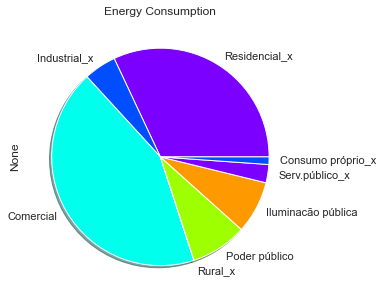

In [786]:
time[targets].iloc[:, 1:9].mean().plot(kind='pie', shadow=True, figsize=(7,5), title='Energy Consumption')

# Feature Selection

#### Note: Remember to fill missing values with means of same neighborhood

In [787]:
targets = ['Consumo de energia elétrica (MWh)', 'Residencial_x',        # Energy related variables
       'Industrial_x', 'Comercial', 'Rural_x', 'Poder público ',
       'Iluminacão pública', 'Serv.público_x', 'Consumo próprio_x',
       'Consumo resdencial de energia elétrica (MWh)',
       'Médio anual por unidade consumidora  ',
       'Total de unidades consumidoras  residenciais ', 'Total_y.1',
       'Residencial_y', 'Industrial_y', 'Comercial ', 'Rural_y',
       'Poderes públicos ', 'Iluminação pública', 'Serv.público_y',
       'Consumo próprio_y']

In [788]:
i=-1

In [790]:
i+=1
target = targets[i]
print(i, target)

1 Residencial_x


### X and Y Definition:

In [791]:
x = time.drop(targets, axis=1).iloc[:, 2:]

In [792]:
y = time[[target]]

# Feature Encoding

#### Choosing Intervals for Categories

In [793]:
bins = [y[target].min()-1, 26000, 67000, 102000, 176000, 250000, y[target].max()+1]
labels=[float(i) for i in range(len(bins)-1)]

In [794]:
y_cat = pd.cut(y[target], bins, right=True, labels=labels)

In [ ]:
y.plot.hist(bins=150, figsize=(22, 10))            # Used to determine the boundary between between new labels

plt.xticks(np.linspace(-1e4, 3e5,31), fontsize=11)
plt.grid()

In [ ]:
fig = plt.figure()                               # Used to visualize new labels intervals.
ax0 = fig.add_subplot(111)

y.plot(kind='hist', bins=40, figsize=(8,5), ax=ax0)
u = np.linspace(0,235,100)
[ax0.plot( u*0 + bins[i], u, color='orange') for i in range(len(bins))]
plt.show()

#### Optional: Encoding with Ordinal/Label Encoder

In [797]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

In [727]:
y_cod = OrdinalEncoder().fit_transform(y_cat.to_frame())       # Apperently not working. Or - plotting is not sharing the same scale. 
y_cod = pd.Series(y_cod.ravel())                               # Update: y_cod leading to different correlation results

In [728]:
y_cod[55:60], y_cat[55:60]

(55    0.0
 56    0.0
 57    0.0
 58    0.0
 59    1.0
 dtype: float64,
 64    0.0
 65    0.0
 66    0.0
 67    0.0
 68    1.0
 Name: Residencial_x, dtype: category
 Categories (6, float64): [0.0 < 1.0 < 2.0 < 3.0 < 4.0 < 5.0])

### Encoded Testing

In [735]:
#y_grp = pd.concat([y, y_cod], axis=1)        # change to test 'cut' output or label/Ordinal Encoder Output
y_grp = pd.concat([y, y_cat], axis=1)
 
y_grp.columns=['Residencial_x', 'category']

In [736]:
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_palette('gist_rainbow_r')

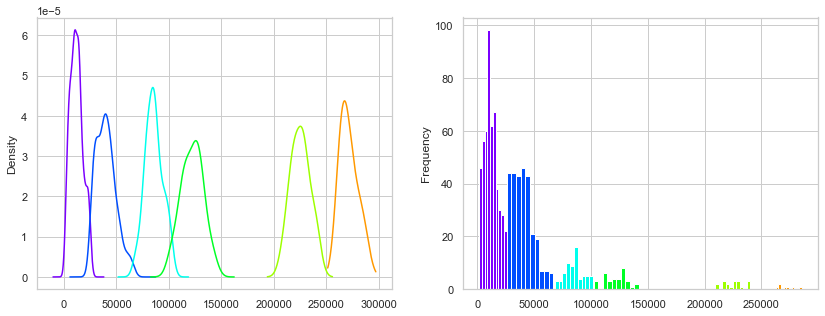

In [737]:
fig = plt.figure(figsize=(14,5))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

for i in labels:                   # change to test 'cut' output or label/Ordinal Encoder Output
#for i in range(len(labels)):
    
    #print((y_grp[y_grp['category']==i]['Residencial_x'].mean()))
    y_grp[y_grp['category']==i]['Residencial_x'].plot(kind='kde', ax=ax0)
    y_grp[y_grp['category']==i]['Residencial_x'].plot(kind='hist', ax=ax1, bins=10)

#### Idea: Transform back bins limits and plot real values distributions

### Correlation Analysis

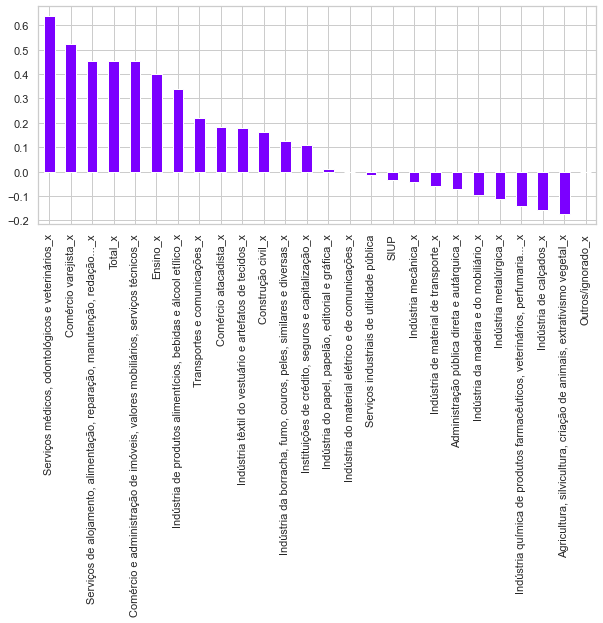

In [746]:
x.iloc[:, 2:28].corrwith(y_cat).sort_values(ascending=False).plot(kind='bar', figsize=(10,4))

In [ ]:
x.iloc[:, 28:55].corrwith(y_cat).sort_values(ascending=False).plot(kind='bar', figsize=(10,4))

In [ ]:
x.iloc[:, 55:].corrwith(y_cat).sort_values(ascending=False).plot(kind='bar', figsize=(10,4))

# Log Transformation

In [382]:
#y = y.apply(np.log1p)

In [383]:
x = x.apply(np.log1p)

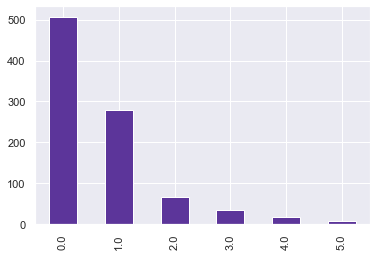

In [384]:
y_cat.value_counts().plot(kind='bar')

# Normalization

In [385]:
scaler = MinMaxScaler()
x_norm = scaler.fit_transform(x)
#y_norm = scaler.fit_transform(y)

scaler = StandardScaler()
x_norm = scaler.fit_transform(x)
y_norm = scaler.fit_transform(y)

x_norm = StandardScaler().fit_transform(x)
y_norm = StandardScaler().fit_transform(y)

# Modeling: K Nearest Neighbors Classifier

### Optimizing k Parameter

1
6
11
16


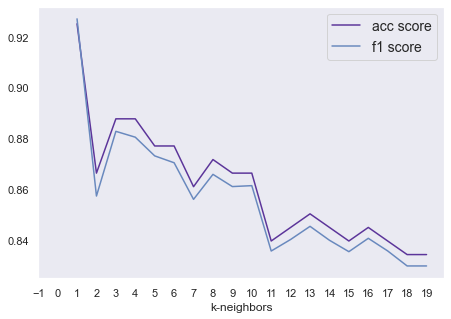

In [386]:
msk = np.random.rand(len(y))<0.8
x_train, y_train, x_test, y_test = x_norm[msk], y_cat[msk], x_norm[~msk], y_cat[~msk]

scrs = []
for i in range(1, 20): 
    
    knn = KNeighborsClassifier(n_neighbors=i).fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    
    scrs.append([i, accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')])
    
    if i in range(1, 100, 5): print(i)

scrs_df = pd.DataFrame(scrs, columns=['k-neighbors','acc score', 'f1 score'])

fig = plt.figure(figsize=(16,5))
ax0 = fig .add_subplot(121)
 
scrs_df.plot(x='k-neighbors', y='acc score', ax=ax0)

scrs_df.plot(x='k-neighbors', y='f1 score', ax=ax0)

plt.legend(loc='upper right', fontsize=14)
plt.xticks(np.arange(-1, 20, 1))
plt.grid()

### Evaluating Model Accuracy Variation on Multiple Random Test Sets

In [389]:
scrs = []
for i in range(1, 101): 
    
    msk = np.random.rand(len(y))<0.8
    x_train, y_train, x_test, y_test = x_norm[msk], y_cat[msk], x_norm[~msk], y_cat[~msk]

    knn = KNeighborsClassifier(n_neighbors=1).fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    
    scrs.append([i, accuracy_score(y_test, y_pred)])
    
    if i in range(1, 101, 10): print(i)

scrs_df = pd.DataFrame(scrs, columns=['k-neighbors','score'])

ax0 = scrs_df['score'].plot(kind='kde')
#scrs_df['score'].plot(kind='hist', bins=25)


### Evaluating Model Output: Predictions

In [556]:
msk = np.random.rand(len(y))<0.85
x_train, y_train, x_test, y_test = x_norm[msk], y_cat[msk], x_norm[~msk], y_cat[~msk]

knn = KNeighborsClassifier(n_neighbors=1).fit(x_train, y_train)
y_pred = knn.predict(x_test)

print(classification_report(y_test, y_pred))
print('')
[print(round(i, 5)) for i in [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')]]

(0.9243697478991597, 0.9207992122167628)

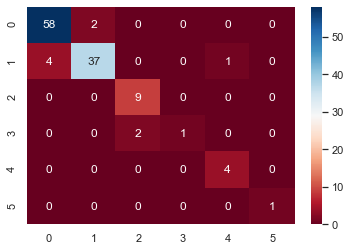

In [559]:
sns.heatmap(confusion_matrix(y_test, y_pred), cmap='RdBu', annot=True)

In [564]:
probs = pd.DataFrame(knn.predict_proba(x_test))    #Can be used to evaluate miss classifications. Check the probability of the true outcomes versus incorrect predicted outcomes